# Hugging Face "Tokenizers"와 PyTorch "Captum" 라이브러리 사용기

최근 자연어 처리 오픈소스 생태계에는 정말 다양한 기능을 수행할 수 있는 라이브러리가 우후죽순으로 등장하고 있습니다.

**Transformers**로 유명한 **Hugging Face**에서는 Rust로 구현된 빠른 속도의 **Tokenizers** 라이브러리를 내놓았고,

페이스북이 운영하는 **PyTorch** 진영에서는 모델의 해석을 돕기 위해 **Captum** 이라는 라이브러리를 공개하였습니다.

두 라이브러리 모두 최신 라이브러리이니 만큼 실제 활용 예제가 많지 않지만, 앞으로 여러 모로 활용하기 좋을 라이브러리인 것 같아 **한국어 데이터**를 적용해 해당 라이브러리를 공부해볼 수 있는 작은 **튜토리얼 자료**를 만들어보았습니다. 많은 도움이 되셨으면 좋겠습니다 :)

P.S 본 튜토리얼은 **Tokenizers**의 [**공식 예제**](https://github.com/huggingface/tokenizers/tree/master/bindings/python/examples)와 **Captum**의 [**공식 튜토리얼**](https://captum.ai/tutorials/IMDB_TorchText_Interpret)을 참조하여 만들어졌습니다.

## 1. 데이터 추출 및 훈련 데이터 생성

- 먼저 **NSMC 코퍼스** 내 훈련 데이터셋을 이용해 **문장 데이터**와 **라벨 데이터**를 구축해줍니다.
- 훈련 데이터셋 내 `nan`으로 찍히는 문장이 약 **5건** 존재하므로 해당 문장들을 제거해주기 위한 **조건문**을 걸어줍니다.

In [26]:
import pandas as pd

# NSMC 훈련용 코퍼스 내 문장 및 라벨 데이터 추출

f_train = pd.read_csv('data/ratings_train.txt', sep='\t')
train_pair = [(row[1], row[2]) for _, row in f_train.iterrows() if type(row[1]) == str]

train_data  = [pair[0] for pair in train_pair]
train_label = [pair[1] for pair in train_pair]

추출한 문장 데이터와 라벨 데이터를 일부 출력해 데이터가 잘 구축되었는지 확인합니다.

In [27]:
# 추출된 문장 및 라벨 데이터 일부 확인

for data, label in zip(train_data[:3], train_label[:3]):
    print(f'문장: {data}\n라벨: {label}\n')

문장: 아 더빙.. 진짜 짜증나네요 목소리
라벨: 0

문장: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
라벨: 1

문장: 너무재밓었다그래서보는것을추천한다
라벨: 0



## 2. Tokenizers 라이브러리 활용한 토크나이저 학습

- 프로젝트 전반에 사용될 **변수 사전**을 정의해줍니다.
- **CLI 환경**에서는 `argparse`, `fire` 등 목적에 맞는 라이브러리를 이용해주는 것이 좋지만,
- **주피터 환경**에서의 실험이므로 **파이썬 딕셔너리**를 활용해 간단하게 구현해주었습니다.

In [28]:
# 프로젝트 전반에 사용될 변수 사전 정의

params = {
    'batch_size': 64,
    'num_epoch': 15,
    'lr': 0.003,
    'dropout': 0.5,
    'min_frequency': 3,
    'max_len': 20,
    
    'vocab_size': 20000,
    'embed_dim': 100,
    'hidden_dim': 256,
    'filter_sizes': [2, 3, 4],
    'num_filters': 100,
    'output_dim': 1,
}

앞서 추출한 문장 데이터들을 **새로운 텍스트 파일**에 저장해줍니다. 해당 텍스트 파일은 **Hugging Face 토크나이저**를 **학습**하는데 사용됩니다.

In [29]:
# 추출한 문장 데이터 텍스트 파일로 저장

with open('train_tokenizer.txt', 'w', encoding='utf-8') as f:
    for line in train_data:
        print(line, file=f)

- **Hugging Face** 토크나이저를 학습시켜줄 때 우리는 다음을 **인자**로 넘겨줄 수 있습니다.
    - `vocab_size`: 사전의 최대 크기
    - `min_frequency`: 단어의 최소 발생 빈도
    - `suffix`: 토큰 뒤에 붙을 접미사 (기본 값:  **<\/w>**)
    - `special_tokens`: 스페셜 토큰으로 취급할 토큰들의 리스트
- 각 인자들을 상황에 맞게 채워준 후, 토크나이저를 **훈련**시킵니다.

In [99]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

# Initialize a tokenizer
tokenizer = Tokenizer(models.BPE.empty())

# # Customize pre-tokenization and decoding
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace.new()
# tokenizer.decoder = decoders.ByteLevel.new()

# And then train
trainer = trainers.BpeTrainer.new(
    vocab_size=20000, 
    min_frequency=2, 
    suffix='', 
    special_tokens=['<pad>', '<sos>', '<eos>', '<unk>']
)
tokenizer.train(trainer, ['train_tokenizer.txt'])

In [98]:
tokenizer = Tokenizer(models.BPE.empty())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace.new()

AttributeError: module 'tokenizers.pre_tokenizers' has no attribute 'WhitespaceSplit'

In [103]:
print(tokenizer.token_to_id('<unk>'))

3


In [107]:
encoded = tokenizer.encode("뚫 뷁 뷁 뤻 흐힇")
print(encoded.tokens)

['뚫', '뷁', '뷁', '흐']


In [72]:
from tokenizers import BPETokenizer

# BPE 토크나이저 초기화

tokenizer = BPETokenizer()


# 앞서 제작한 텍스트 파일 활용해 토크나이저 훈련

tokenizer.train(
    'train_tokenizer.txt',
    vocab_size=params['vocab_size'],
    min_frequency=params['min_frequency'],
    suffix='',
    special_tokens=['<pad>', '<sos>', '<eos>', '<unk>'],
)

In [70]:
tokenizer = BPETokenizer()

In [74]:
tokenizer._parameters

{'model': 'BPE', 'unk_token': '<unk>', 'suffix': '</w>', 'dropout': None}

- 이후 사용될 **스페셜 토큰**들의 id 값을 **변수로 저장**해줍니다.
- **'unk'**의 경우 토큰화 과정 중 자동으로 적용되는 토큰입니다.

In [59]:
# 패딩 토큰 인덱스 확인

print(tokenizer.token_to_id('<pad>'))

0


In [60]:
# 스페셜 토큰 변수화

pad_idx = tokenizer.token_to_id('<pad>')
sos_idx = tokenizer.token_to_id('<sos>')
eos_idx = tokenizer.token_to_id('<eos>')

- 토크나이저에 **패딩 옵션**을 부여해줍니다.
- 이때 인자로는 **패딩 토큰의 아이디**, **실제 패딩 토큰** 그리고 **문장의 최대 길이**를 넘겨주어야 합니다.

In [61]:
# 토크나이저에 대해 패딩 옵션 설정

tokenizer.enable_padding(pad_id=pad_idx, pad_token='<pad>', max_length=params['max_len'])

- Rust로 구현된 `encode_batch` 함수를 이용해 **전체 데이터셋**에 대해 토크나이즈를 수행합니다.
- 시간을 측정해 본 결과, 약 15만건의 문장이 무려 **1초** 이내에 모두 토크나이즈 되었습니다.

In [62]:
# 'encode_batch' 함수 이용해 훈련 데이터셋에 대해 토크나이즈 수행

encoded_data = tokenizer.encode_batch(train_data)

In [63]:
# 데이터 개수 확인

print(f'훈련 데이터:\t{len(train_data)} 개')
print(f'훈련 라벨:\t{len(train_label)} 개')
print(f'인코딩 데이터:\t{len(encoded_data)} 개')

훈련 데이터:	149995 개
훈련 라벨:	149995 개
인코딩 데이터:	149995 개


**패딩 옵션**을 적용한 후, 토큰화가 수행된 결과를 확인합니다.

In [79]:
e = tokenizer.encode('야 부렉 뷁 뷁dasdsadds')
e.tokens

['야', '부', '렉', 'd', 'as', 'd', 's', 'ad', 'd', 's']

In [66]:
# 토크나이저 초기 훈련 결과 확인

print(f'토큰: {encoded_data[2020].tokens}\n')
print(f'아이디: {encoded_data[2020].ids}')

토큰: ['20', '여', '년이', '흘러', '두', '기억에', '남는', '사랑에', '대해', '생각해', '볼수있는', '유쾌한', '영화', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

아이디: [1215, 646, 1957, 2401, 290, 1664, 1309, 2876, 1826, 2161, 3921, 2862, 1004, 0, 0, 0, 0, 0, 0, 0]


## 3. 토크나이즈 결과 후처리

- 라이브러리를 통해 토큰화 작업은 모두 완료되었지만, **후처리 작업**을 따로 수행해주어야 합니다.
    - **Hugging Face** 측에서는 후처리 작업을 따로 수행하는 `post_processor` 파이프가 파이프 라인에 포함되어 있다고 설명하였지만, 
    - 현재까지는 **BERT** 관련 후처리 파이프만 존재하는 듯 합니다.
- 먼저, 전체 토큰 리스트에 문장의 시작을 알리는 **'SOS' 토큰**을 추가해줍니다.


- 이후 **최대 길이**를 넘는 문장들을 모두 **최대 길이**에 맞게 슬라이스 연산을 통해 잘라줍니다.
- 문장이 짧아 패딩 토큰이 포함된 문장은 첫 번째 패딩 토큰을 **'EOS'** 토큰으로 변경해줍니다.
- 패딩 토큰이 포함되지 않은 문장은 시퀀스 말미에 **'EOS' 토큰**을 삽입해줍니다.

In [13]:
# 후처리 함수 정의

def postprocess(input_ids):
    input_ids = [sos_idx] + input_ids
    
    # 문장 최대 길이까지 슬라이싱
    input_ids = input_ids[:params['max_len']]

    # 패딩 토큰이 포함된 문장이라면 원 문장 말미에 <EOS> 토큰 삽입 
    if pad_idx in input_ids:
        pad_start = input_ids.index(pad_idx)
        input_ids[pad_start] = eos_idx

    # 패딩 토큰이 포함되지 않은 문장이라면, 시퀀스 말미에 <EOS> 토큰 삽입
    else:
        input_ids[-1] = eos_idx
    
    return input_ids

- 정의한 **후처리 함수**를 이용해 모든 시퀀스에 **후처리** 로직을 적용합니다.
- 이후, 후처리가 이전 시퀀스들에 잘 적용되었는지 확인합니다.

In [14]:
# 후처리 함수 이용해 토크나이즈 문장 후처리

processed_data = [postprocess(data.ids) for data in encoded_data]

In [15]:
# 후처리 결과 확인

print(f'후처리 결과: {processed_data[2020]}\n')
print(f'후처리 결과 디코딩: {tokenizer.decode(processed_data[2020])}')

후처리 결과: [1, 1216, 647, 1958, 2402, 291, 1665, 1310, 2877, 1827, 2162, 3922, 2863, 1005, 2, 0, 0, 0, 0, 0]

후처리 결과 디코딩: <SOS>20여년이흘러두기억에남는사랑에대해생각해볼수있는유쾌한영화<EOS><PAD><PAD><PAD><PAD><PAD>


## 4. 간단한 CNN 문장 분류기 구현

- 이제 문장 분류에 사용할 간단한 **CNN** 기반의 텍스트 분류기를 정의합니다.
- 간단한 모델이니 만큼, 별다른 설명은 달지 않습니다.
- 모델에 대한 이해를 필요로하시는 분들은 **튜토리얼 하단**에 **읽을 거리**를 참조해주세요.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils import data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# CNN 모델 정의

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(params['vocab_size'], params['embed_dim'], padding_idx=pad_idx)

        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, 
                                              out_channels=params['num_filters'], 
                                              kernel_size=(fs, params['embed_dim'])) 
                                    for fs in params['filter_sizes']])
        
        self.fc = nn.Linear(len(params['filter_sizes']) * params['num_filters'], 1)
        
        self.dropout = nn.Dropout(params['dropout'])
        
    def forward(self, input_ids):
        # input_ids    = [배치 사이즈, 문장 길이]

        embedded = self.embedding(input_ids).unsqueeze(1)
        # embedded     = [배치 사이즈, 채널 개수, 임베딩 차원]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n     = [배치 사이즈, 필터 개수, 문장 길이 - 필터 리스트[n] + 1]
        
        max_pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # max_pooled_n = [배치 사이즈, 필터 개수]

        cat = self.dropout(torch.cat(max_pooled, dim = 1))
        # cat          = [배치 사이즈, 필터 개수 x len(필터 리스트)]

        return self.fc(cat)  # [배치 사이즈, 1]

## 5. 데이터 텐서 변환

- 이제 앞서 구축한 문장 및 라벨 데이터를 `torch.Tensor` 형으로 변환해줍니다.
- 변환 이후, `DataLoader`를 이용해 **batchify** 시켜줍니다.

In [18]:
# 문장 및 라벨 데이터 torch Tensor로 변환

processed_data = [torch.LongTensor(data).to(device) for data in processed_data]
train_label = [torch.FloatTensor([label]).to(device) for label in train_label]


# torch Tensor로 변환한 데이터 이용해 Iterator 정의

train_iter = data.DataLoader(processed_data, batch_size=params['batch_size'])
label_iter = data.DataLoader(train_label, batch_size=params['batch_size'])

## 6. 데이터셋 이용해 CNN 모델 훈련

이제 본격적으로 기정의한 모델과 데이터셋을 이용한 학습을 시작합니다.

In [19]:
model = CNN()
model.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=params['lr'])

for epoch in range(params['num_epoch']):
    model.train()
    epoch_loss = 0
    
    for (batch, label) in zip(train_iter, label_iter):
        optimizer.zero_grad()

        logits = model(batch).squeeze(1)    # [배치 사이즈]
        labels = label.view(label.size(0))  # [배치 사이즈]

        loss = criterion(logits, labels)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = epoch_loss / len(train_iter)        
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f}')

Epoch: 01 | Train Loss: 0.467
Epoch: 02 | Train Loss: 0.344
Epoch: 03 | Train Loss: 0.303
Epoch: 04 | Train Loss: 0.272
Epoch: 05 | Train Loss: 0.240
Epoch: 06 | Train Loss: 0.207
Epoch: 07 | Train Loss: 0.183
Epoch: 08 | Train Loss: 0.165
Epoch: 09 | Train Loss: 0.147
Epoch: 10 | Train Loss: 0.133


## 7. Captum을 이용한 모델 해석

PyTorch 진영에서 공식적으로 관린하는 **Captum**은 모델 해석을 위한 **여러 기법**들을 **구현한 모듈**을 제공해주는 라이브러리입니다.

이번 튜토리얼에서는 **Captum**을 이용해 간단하게 모델이 어떠한 부분을 보고 판단을 결정했는지에 대해 살펴볼 예정입니다.

- 본 튜토리얼에 사용되는 **Captum**의 `LayerIntegratedGradients` 모듈이 현 배포판에 포함되어 있지 않다고 합니다. (2020년 1월 기준)
- 때문에 [**Github repo**](https://github.com/pytorch/captum)를 clone해 수동으로 설치해주셔야 합니다!
- 본인이 이용하는 파이썬 버전의 `site-packages` 폴더로 이동해 다음 명령어들을 실행시켜주시면 됩니다.

```bash
git clone https://github.com/pytorch/captum.git
cd captum
pip install -e .
pip install -e .[tutorials]
```

설치를 마친 후, 본 튜토리얼에 사용되는 **API 모듈**을 임포트 및 정의합니다.

In [20]:
# 결과 해석에 필요한 Captum API 임포트 및 정의

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

token_reference = TokenReferenceBase(reference_token_idx=pad_idx)  # 레퍼런스 생성 위한 모듈
lig = LayerIntegratedGradients(model, model.embedding)             # 결과 해석에 사용되는 IntegratedGradient 기법 모듈

- 결과 분석을 위한 **비교 문장**을 생성할 `interpret_sentence` 함수와,
- 각 결과를 `VisualziationDataRecord` **클래스 인스턴스**로 저장해 줄 `add_attributions_to_visualizer` 함수를 정의합니다.

In [21]:
vis_data_records_ig = []

label_vocab  = {0: '부정', 1: '긍정'}

def interpret_sentence(model, sentence, label = 0):       
    model.zero_grad()
    
    input_ids = tokenizer.encode(sentence)
    input_tokens = input_ids.tokens[:params['max_len']]
    
    input_ids = postprocess(input_ids.ids)
    input_indices_tensor = torch.LongTensor(input_ids).to(device).unsqueeze(0)

    # 단일 문장에 대한 예측 작업 수행
    pred = torch.sigmoid(model(input_indices_tensor)).item()
    pred_ind = round(pred)

    # 베이스 라인 역할을 할 Reference 생성: 주로 패딩 토큰으로 채워줌
    reference_indices = token_reference.generate_reference(params['max_len'], device=device).unsqueeze(0)

    # LayerIntegratedGradients 모듈 활용해 개별 단어의 속성값 및 델타값 근사치 계산
    attributions_ig, delta = lig.attribute(input_indices_tensor, reference_indices, n_steps=500, return_convergence_delta=True)

    print('pred: ', label_vocab[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, input_tokens, pred, pred_ind, label, delta, vis_data_records_ig)
    

def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # 시각화 위해 샘플을 리스트에 추가
    vis_data_records.append(visualization.
                                VisualizationDataRecord(
                                    attributions,
                                    pred,
                                    label_vocab[pred_ind],
                                    label_vocab[label],
                                    label_vocab[1],
                                    attributions.sum(),       
                                    text,
                                delta
                                )
                           )

- 앞서 정의한 함수들을 활용해 학습되지 않은 **임의의 문장**을 실험 결과에 추가합니다.
- 해당 문장들은 제가 최근 재밌게 보았던 영화 **Knives Out**의 네이버 리뷰입니다.
- 튜토리얼이라는 목적에 맞게 모호한 리뷰보다는 **모델이 구분하기 쉬울만한 리뷰**들을 따로 선별하였습니다.

In [22]:
# 예제 문장 추가 및 분석 수행

interpret_sentence(model, '보면후회하지않을 영화였다 아쉬운부분이 없었고 마지막까지 긴장감있었다', label=1)
interpret_sentence(model, '평이 워낙 좋아 갔는데 거품이 심한듯.. 개연성도 엉망에 르부아 블랑의 뜬금없는 직관에만 의존한 스토리 전개 ;; 평점 거품이 심한듯', label=0)
interpret_sentence(model, '너무 재미있게 봤습니다. 클래식한 추리소설 느낌.타 인기영화때문에 개봉관이 적어 아쉽네요', label=1)
interpret_sentence(model, '아, 2시간 넘게 지루하고 어이없는 추격전과 의욕이 넘쳐 과욕으로 변한 연기, 게다가 예상보다 너무 뻔한 결말로 고문당함.', label=0)

pred:  긍정 ( 1.00 ) , delta:  tensor([4.6605], device='cuda:0')
pred:  부정 ( 0.00 ) , delta:  tensor([2.9982], device='cuda:0')
pred:  긍정 ( 1.00 ) , delta:  tensor([5.3574], device='cuda:0')
pred:  부정 ( 0.00 ) , delta:  tensor([10.6374], device='cuda:0')


앞선 함수의 호출로 결과가 저장된 `vis_data_records_ig` 리스트를 활용해 **시각화 결과**를 그려주도록 합니다.

In [23]:
# 시각화 결과 표 변환

visualization.visualize_text(vis_data_records_ig)

Target Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
긍정,긍정 (1.00),긍정,1.32,보면 후회하지 않을 영화였다 아쉬운 부분이 없었고 마지막까지 긴장감 있었다 #PAD #PAD #PAD #PAD #PAD #PAD #PAD #PAD #PAD #PAD
부정,부정 (0.00),긍정,-1.53,평이 워낙 좋아 갔는데 거품이 심 한듯 .. 개연성도 엉망 에 르 부 아 블 랑 의 뜬금없는 직 관
긍정,긍정 (1.00),긍정,1.17,너무 재미있게 봤습니다 . 클래식 한 추리 소설 느낌 . 타 인기 영화 때문에 개봉 관이 적어 아쉽네요 #PAD #PAD
부정,부정 (0.00),긍정,-1.21,"아 , 2시간 넘게 지루하고 어이없는 추격 전과 의 욕이 넘쳐 과 욕 으로 변한 연기 , 게다가 예상 보다"


아래는 위 함수를 통해 반환된 **HTML 테이블**을 스크린샷으로 찍어 주피터 셀에 그려준 예입니다.

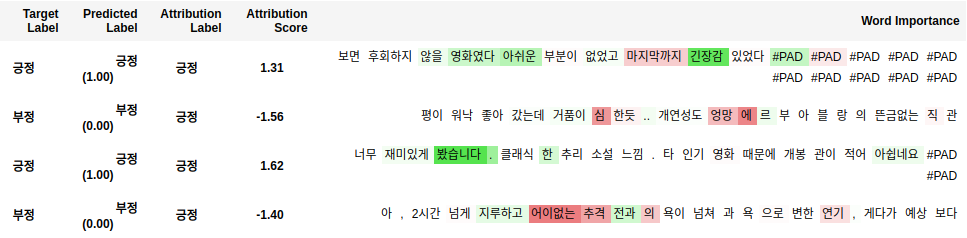

In [24]:
from IPython.display import Image
Image(filename='img/captum_result.png')

### 읽을 거리

- [**Captum**](https://github.com/pytorch/captum) 라이브러리에서 사용한 **_IntegratedGradients_** 기법을 더 자세히 이해하기 위해서는 [**논문**](https://arxiv.org/abs/1703.01365)을 참조해주세요.
- 감정 분류와 관련한 더 많은 학습을 원하시는 분들은 Ben Trevett이 작성한 [**pytorch-sentiment-analysis**](https://github.com/bentrevett/pytorch-sentiment-analysis) 튜토리얼을 참조해주세요. (**강추!**)